**Note**: This notebook should take around **a minute** to run.

For a more comprehensive and detailed treatment of this problem, please refer to the [GitHub repository](https://github.com/HighDimensionalEconLab/deep_learning_transversality).

# The Economic Problem:

Consider the following Bellman equation:

$\begin{align}
    v(k) = & \max_{c, k'}\left\{u(c) + \beta v(k')\right\} \\
    \text{s.t.}~\quad & k' = f(k) + (1 - \delta)k - c \\
    & k' \geq 0,
\end{align}
$

where $v(\cdot)$ is the value function, $u(\cdot)$ is the utility function, $f(\cdot)$ is the production function, $\beta$ is the discount factor, and $\delta$ is the depreciation rate.


#### First Order Condition
The Euler equation can be written as:

$\begin{align}
\quad & u'(c) = \beta u'(c')\big[f'(k')+(1-\delta)\big]
\end{align}$

To pin down the optimal solution a transversality condition is required, described as:

$\begin{align}
\quad & \lim_{T\rightarrow \infty} \beta^T u'(c^T(k))k^{'T}(k) = 0
\end{align}$

for any initial condition of capital $k_0$.

#### The System of Equations Describing the Optimal Solution:


$\begin{align}
\quad & \beta u'\big(c(k)\big)\bigg[f'\big(k'(k)\big)+(1-\delta)\bigg] - u'\big(c(k')\big) = 0 \\
\quad & c(k) = f\big(k\big) + (1-\delta) k - k'(k)  \\
\end{align}$

#### Note on the Transversality Condition:

One of the main contributions of this paper is that one can ignore the transversality condition and completely rely on the implicit bias in deep learning to obtain the optimal solution.



In this example we focus on the case of:
 1. $u(c) =log(c)$, and $f(k) = k^\alpha$,

 2.  $\beta = 0.9$, $\alpha = \frac{1}{3}$, and $\delta = 0.1$.


#### Importing Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
torch.manual_seed(123) # fixing the seed

#### Setting Up the Economic Parameters 


In [3]:
alpha = 1.0/3.0
beta = 0.9
delta = 0.1
k_0 = 1.0

#### Setting Up the Grid ($\mathcal{X}_{\text{train}}$) and the DataLoader

We are looking for the policy function for capital $k'(k): \mathcal{X} \rightarrow \mathbb{R}_+ $, where $\mathcal{X} \subset \mathbb{R}_+$. 

We pick a grid of the following form:

$\begin{align*}
	\mathcal{X}_{\text{train}} \equiv \{k_{\text{min}},\ldots,k_{\text{max}}\}.
\end{align*}$


In [4]:
k_min = 0.4
k_max =4.0
grid_size = 16
capital_grid = torch.linspace(k_min, k_max, grid_size)
capital_grid = capital_grid.unsqueeze(dim =1)

In [5]:
data_loader = DataLoader(capital_grid, batch_size=len(capital_grid), shuffle = False)

#### Setting up the Neural Network

This is an approximation for capital $\hat{k}': \mathcal{X} \rightarrow \mathbb{R}_+$.

$\hat{k}'(\cdot)$ takes capital as an input. The positivity of capital is going to be implemented by using a `Softplus` output layer.

In [6]:
class K_prime_NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,):
        super().__init__()
        
        self.dim_hidden= dim_hidden
        
        self.k_prime = nn.Sequential(
            nn.Linear(1, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, 1),
            nn.Softplus(beta=1.0) #To make sure capital stays positive
        )

    def forward(self, x):
        return self.k_prime(x)
    

#### Initializing the Neural Network and Defining the Optimizer

In [7]:
k_prime= K_prime_NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(k_prime.parameters(), lr=learning_rate) #Adam Optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.95) #dampening the learning rate

In [8]:
num_epochs = 2001 # step of optimization
print_epoch_frequency = 200 # how often printing the results

### Implementing the Economics

Here, we implement the economic conditions in the form of residuals to be minimized. Specifically:

1. The Euler residuals: the difference between the left-hand and right-hand sides of the Euler equation (i.e., Equation 6).

Note: The feasibility condition (i.e., Equation 7) is used to construct the consumption function. Therefore, by construction, Equation 7 always holds.

#### Defining the Marginal Utility, Production, and Marginal Product of Capital Functions

In [9]:
def f(k): # Production function
    return k**alpha

def df_k(k): # Marinal product of capital
    return  alpha*(k**(alpha -1))

def du_c(c): # Mariginal utility
    return c**(-1)

#### Defining the Residuals Function to be Used in the Optimization
This funtion defines the residuals of the Euler equation

In [10]:
def residuals(batch):
    k_t = batch

# iterate forwards
    k_tp1 = k_prime(k_t)
    k_tp2 = k_prime(k_tp1)

# compute consumptions level
    c_t = f(k_t) + (1 - delta) * k_t - k_tp1
    c_tp1 = f(k_tp1) + (1 - delta) * k_tp1 - k_tp2

# Euler residual
    residual = (du_c(c_t) / du_c(c_tp1)) - beta * (1 - delta + df_k(k_tp1))
    return residual
    

#### Training Loop (Optimization Process)

Here, we minimize the mean squared of price residuals over the grid points:

$
\begin{align*}
	min_{\theta\in \Theta} \frac{1}{|\mathcal{X}_{\text{train}}|} \sum_{k \in \mathcal{X}_{\text{train}}} \Bigg( &	\frac{u'\big(c\big(k,k'(\cdot;\theta)\big)\big)}{u'\big(c\big(k'(k;\theta);k'(\cdot;\theta)\big)\big)} - \beta \big[f'\big(k'(k;\theta)\big) + (1-\delta)\big]\Bigg)^2.
\end{align*}
$

where $\theta$ is the coefficients of the neural network, and the optimization id done with gradient-based optimizers such as `Gradient Descent (GD)` and `Adam`.  


In [11]:
for epoch in range(num_epochs):
    for batch in data_loader:
        
        optimizer.zero_grad()
        
        res = residuals(batch)
        
        loss = res.pow(2).mean()
        
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    
    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")


epoch = 0, loss = 6.71e-01
epoch = 200, loss = 1.45e-04
epoch = 400, loss = 1.02e-04
epoch = 600, loss = 7.38e-05
epoch = 800, loss = 5.36e-05
epoch = 1000, loss = 3.79e-05
epoch = 1200, loss = 2.55e-05
epoch = 1400, loss = 1.63e-05
epoch = 1600, loss = 9.71e-06
epoch = 1800, loss = 5.49e-06
epoch = 2000, loss = 3.37e-06


### Plotting the Results

#### Calculating the Steady-State for Capital and Consumption
The steady-state for capital and consumption is used to test the convergence to the optimal solution 

In [12]:
base = ((1.0/beta)-1.0+ delta)/alpha
exponent = 1.0/(alpha-1)

k_star = base**exponent
c_star = f(k_star)-delta*k_star

In [13]:
# creating the test data: we test for the capital path that starts k_0=0.5
test_T = 50
k_0 =0.5
k_hat_path  = torch.empty(test_T+1).unsqueeze(1)
c_hat_path = torch.empty(test_T).unsqueeze(1)
time_grid = torch.arange(test_T).unsqueeze(1)

In [14]:
k_hat_path[0] =k_0

#### Calculating the Approximate Capital and Consumption Path

We use approximated $\hat{k}'(k)$ (by neural network) to calculate capital and consumption paths.  


In [15]:
for t in range(0, test_T):
    k_hat_path[t+1] = k_prime(k_hat_path[t])
    c_hat_path[t] = f(k_hat_path[t]) + (1-delta)*k_hat_path[t] - k_hat_path[t+1]
    
k_hat_path =k_hat_path.detach()
c_hat_path =c_hat_path.detach()
time_grid = time_grid.detach()

#### Calculating the Euler Residuals



In [16]:
res = residuals(k_hat_path[0:test_T])
res = res.detach()

#### Plots

We firstly set up the plots parmeters

In [17]:
fontsize= 14
ticksize = 14
figsize = (14, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

Next we plot the approximate capital and consumption plots

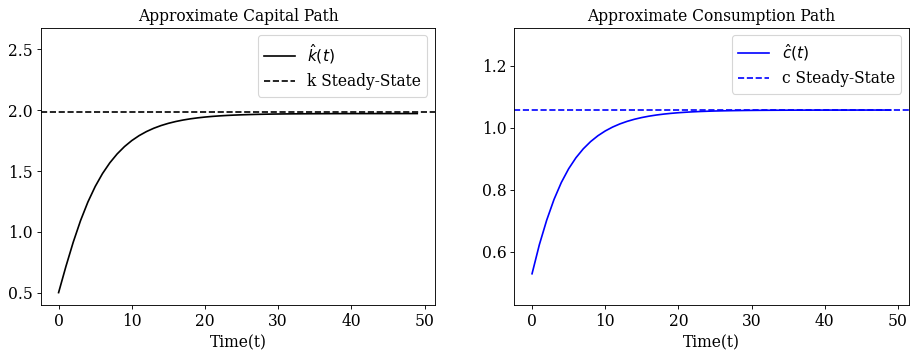

In [18]:
plt.subplot(1, 2 , 1)

plt.plot(time_grid,k_hat_path[0:test_T], color='k',  label = r"$\hat{k}(t)$")
plt.axhline(y=k_star, linestyle='--',color='k', label="k Steady-State")
plt.xlabel(r"Time(t)")
plt.title(r"Approximate Capital Path")
plt.ylim([k_0-0.1,k_star*(1+0.35) ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)

plt.plot(time_grid,c_hat_path, color='b',  label = r"$\hat{c}(t)$")
plt.axhline(y=c_star, linestyle='--',color='b', label="c Steady-State")
plt.xlabel(r"Time(t)")
plt.title(r"Approximate Consumption Path")
plt.ylim([c_hat_path[0]-0.1,c_star*(1+0.25) ])
plt.legend(loc='best')

Lastly we plot residuals 

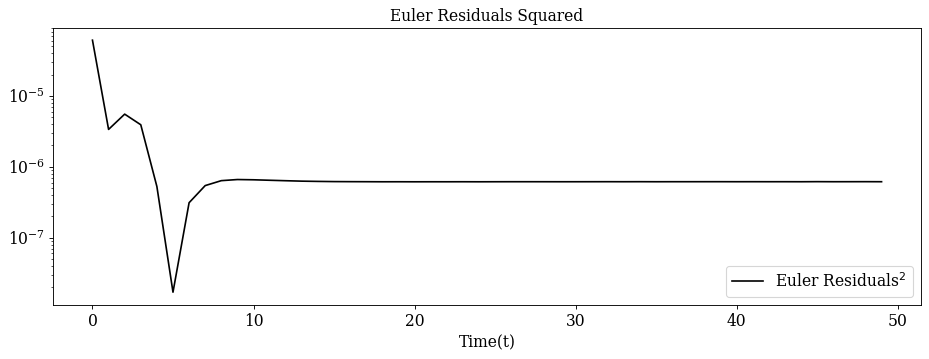

In [19]:
plt.plot(time_grid,res**2, color='k',  label = r"Euler Residuals$^2$")
plt.xlabel(r"Time(t)")
plt.title(r"Euler Residuals Squared")
plt.legend(loc='lower right')
plt.yscale('log')